# Praca domowa nr 4, Warsztaty Badawcze ML 2



Jędrzej Sokołowski 22.05.2022

### Wczytanie danych oraz potrzebnych pakietów

In [48]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, mean_squared_log_error, r2_score, recall_score, mean_squared_error

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

cat_test_df = pd.read_csv("test_cat.csv")
cat_train_df = pd.read_csv("train_cat.csv")
cars_df = pd.read_csv("Car_Prices_Poland.csv")

## Wstęp

Poniższy raport ma na celu analizę i wytłumaczenie sposobów działania modeli stworzonych w Pracy Domowej 2, która zawierała testowanie modeli `Random Forest` oraz `XGBoost` na zadaniach klasyfikacji i regresji dotyczących zbiorów danych posiadających informacje o pasażerach lini lotniczych oraz cenach samochodów w Polsce.

Disclamer: Umknęło mi zdanie w treści zadania mówiące o tym, żeby wybrać jeden model i zbiór danych, dlatego analizowałem wszystkie.

## Dane z zadaniem klasyfikacji

### Preprocessing oraz odtworzenie najbardziej dokładnych modeli


In [3]:
def show_model_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"F1 score: {f1_score(y_val, y_pred, average=None)}")
    print(f"F1 score micro: {f1_score(y_val, y_pred, average='micro')}")
    print(f"F1 score weighted: {f1_score(y_val, y_pred, average='weighted')}")
    print(f"Precision score: {precision_score(y_val, y_pred, average=None)}")
    print(f"Recall score: {recall_score(y_val, y_pred, average=None)}")

In [4]:
le_train = LabelEncoder()
le_test = LabelEncoder()

integer_encoded_train = le_train.fit_transform(cat_train_df["satisfaction"])
integer_encoded_test = le_test.fit_transform(cat_test_df["satisfaction"])

cat_train_df["satisfaction"] = integer_encoded_train
cat_test_df["satisfaction"] = integer_encoded_test

cat_train_df['Gender'] = (cat_train_df['Gender'] == 'Female')*1
cat_test_df['Gender'] = (cat_test_df['Gender'] == 'Female')*1

In [5]:
cat_test_df = cat_test_df.drop(columns = ["Unnamed: 0", "id"], axis=1)
cat_train_df = cat_train_df.drop(columns = ["Unnamed: 0", "id"], axis=1)

cat_test_df = cat_test_df[~cat_test_df["Arrival Delay in Minutes"].isna()]
cat_train_df = cat_train_df[~cat_train_df["Arrival Delay in Minutes"].isna()]

numeric_columns = list(cat_train_df._get_numeric_data().columns)
numeric_columns.remove('satisfaction')
numeric_columns.remove('Gender')

for col in numeric_columns:
    transf1 = cat_test_df[col].values.reshape(-1,1)
    scaler1 = StandardScaler().fit(transf1)
    cat_test_df[col] = scaler1.transform(transf1)
    
    transf2 = cat_train_df[col].values.reshape(-1,1)
    scaler2 = StandardScaler().fit(transf2)
    cat_train_df[col] = scaler2.transform(transf2)
    
encoded_test = pd.get_dummies(cat_test_df[["Customer Type","Type of Travel", "Class"]].astype(str))
encoded_test = encoded_test.drop(["Customer Type_Loyal Customer", "Type of Travel_Business travel", "Class_Business"], axis = 1)

cat_test_df = cat_test_df.drop(["Customer Type","Type of Travel", "Class"], axis=1)
cat_test_df = pd.concat([cat_test_df, encoded_test], axis = 1)

encoded_train = pd.get_dummies(cat_train_df[["Customer Type","Type of Travel", "Class"]].astype(str))
encoded_train = encoded_train.drop(["Customer Type_Loyal Customer", "Type of Travel_Business travel", "Class_Business"], axis = 1)

cat_train_df = cat_train_df.drop(["Customer Type","Type of Travel", "Class"], axis=1)
cat_train_df = pd.concat([cat_train_df, encoded_train], axis = 1)

In [6]:
y_train = cat_train_df["satisfaction"]
X_train = cat_train_df.drop("satisfaction", axis= 1)
y_test = cat_test_df["satisfaction"]
X_test = cat_test_df.drop("satisfaction", axis= 1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=420, test_size=0.125)

#### RandomForest

In [7]:
rndForest1 = RandomForestClassifier(max_depth=20)
rndForest1.fit(X_train, y_train)
y_pred = rndForest1.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.9615340053296257


In [8]:
print("Train set")
show_model_metrics(rndForest1, X_train, y_train)
print("----------")
print("Val set")
show_model_metrics(rndForest1, X_val, y_val)

Train set
F1 score: [0.99565146 0.99424617]
F1 score micro: 0.9950465557565862
F1 score weighted: 0.9950440829708149
Precision score: [0.99258487 0.99832724]
Recall score: [0.99873705 0.99019833]
----------
Val set
F1 score: [0.96631521 0.95643705]
F1 score micro: 0.962007722007722
F1 score weighted: 0.9619520381336211
Precision score: [0.95675163 0.96896304]
Recall score: [0.97607192 0.94423077]


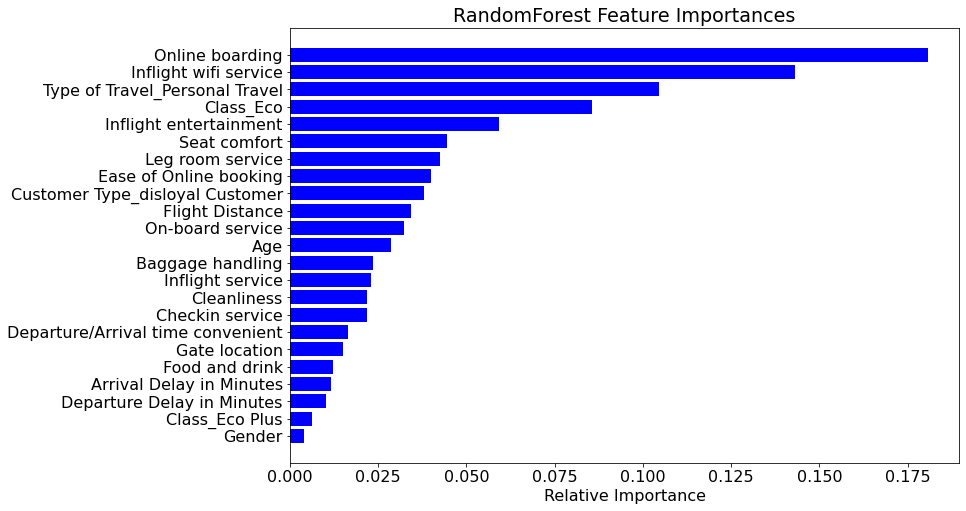

In [9]:
importances = rndForest1.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('RandomForest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [11]:
import shap

In [22]:
X_sample = shap.utils.sample(X_val, 500)
explainer = shap.Explainer(rndForest1.predict, X_sample)
shap_values = explainer(X_sample)

Permutation explainer: 501it [02:48,  2.80it/s]                         


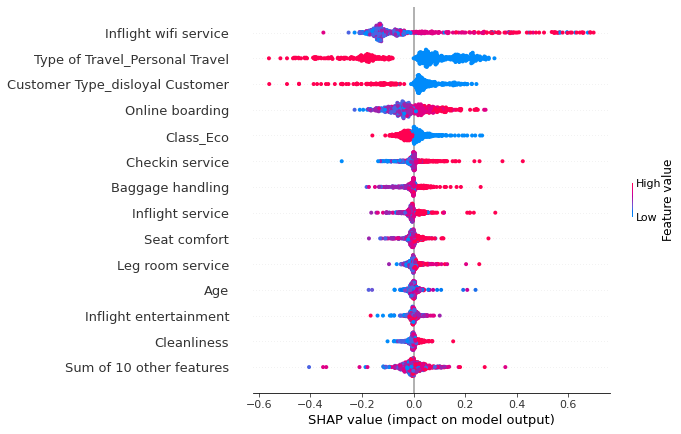

In [13]:
shap.plots.beeswarm(shap_values,max_display=14)

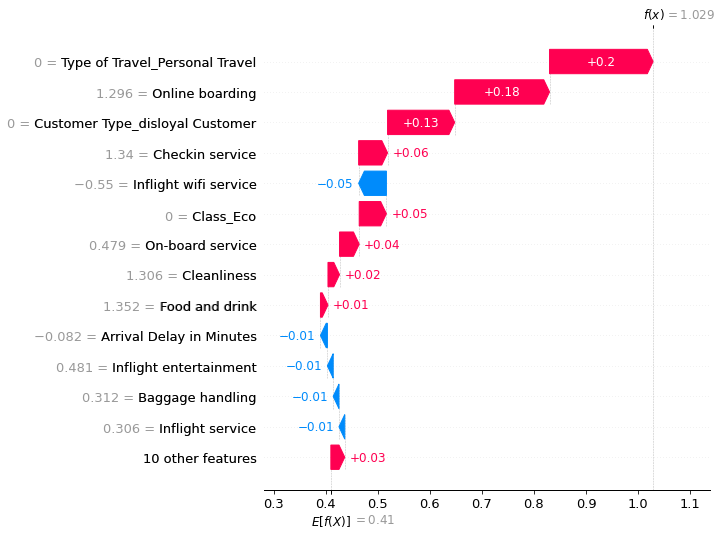

In [14]:
shap.plots.waterfall(shap_values[0], max_display=14)

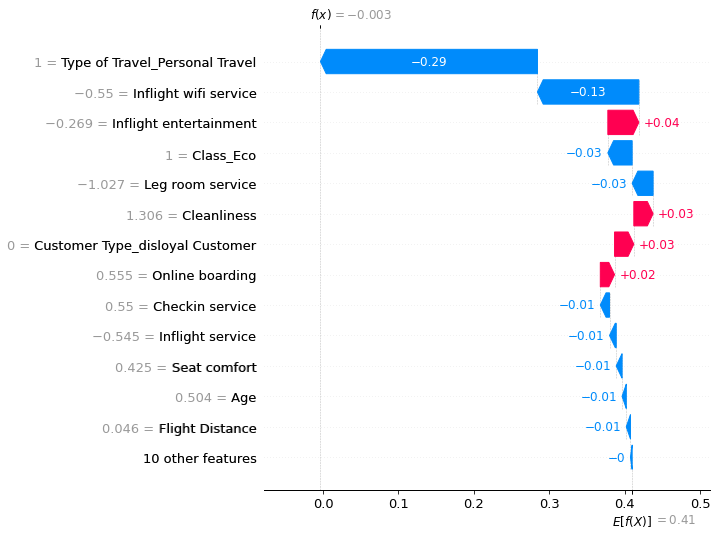

In [15]:
shap.plots.waterfall(shap_values[1], max_display=14)

Z powyższych wykresów wynika, że model `RandomForest` przywiązuje dużą wagę do konkretnych aspektów podróży danego pasażera. Między innymi jest to typ lotu (prywatny lub służbowy), lojalność pasażera, czy na przykład dostępność wifi. Zwykle, gdy podróż była służbowa, odbywała się w lepszej klasie i zawierała więcej pozytywów, które skutkowały satysfakcją pasażera. 

Możemy więc wnioskować, że gdy lot był sponsorowany przez pracodawcę, był na niego przeznaczony większy budżet i zawierał więcej wygód. Wnioski te potwierdzają przeciwne wyniki w przypadku lotów prywatnych.

#### XGBoost

In [16]:
xgb_cls1 = xgb.XGBClassifier(objective="binary:logistic", max_depth=20, seed = 420, use_label_encoder=False)
xgb_cls1.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

[0]	validation_0-error:0.04842
[1]	validation_0-error:0.04432
[2]	validation_0-error:0.04401
[3]	validation_0-error:0.04317
[4]	validation_0-error:0.04239
[5]	validation_0-error:0.04154
[6]	validation_0-error:0.04070
[7]	validation_0-error:0.04023
[8]	validation_0-error:0.03992
[9]	validation_0-error:0.03985
[10]	validation_0-error:0.03938
[11]	validation_0-error:0.03923
[12]	validation_0-error:0.03838
[13]	validation_0-error:0.03807
[14]	validation_0-error:0.03807
[15]	validation_0-error:0.03768
[16]	validation_0-error:0.03768
[17]	validation_0-error:0.03784
[18]	validation_0-error:0.03768
[19]	validation_0-error:0.03761
[20]	validation_0-error:0.03822
[21]	validation_0-error:0.03776
[22]	validation_0-error:0.03807
[23]	validation_0-error:0.03784
[24]	validation_0-error:0.03807
[25]	validation_0-error:0.03822
[26]	validation_0-error:0.03861
[27]	validation_0-error:0.03799
[28]	validation_0-error:0.03846
[29]	validation_0-error:0.03892
[30]	validation_0-error:0.03892
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=420,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=420,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [9]:
xgb_cls1.score(X_test, y_test)

0.9632719267755764

In [17]:
explainer = shap.Explainer(xgb_cls1.predict, X_sample)
shap_values = explainer(X_sample)

Permutation explainer: 501it [00:21, 12.22it/s]                         


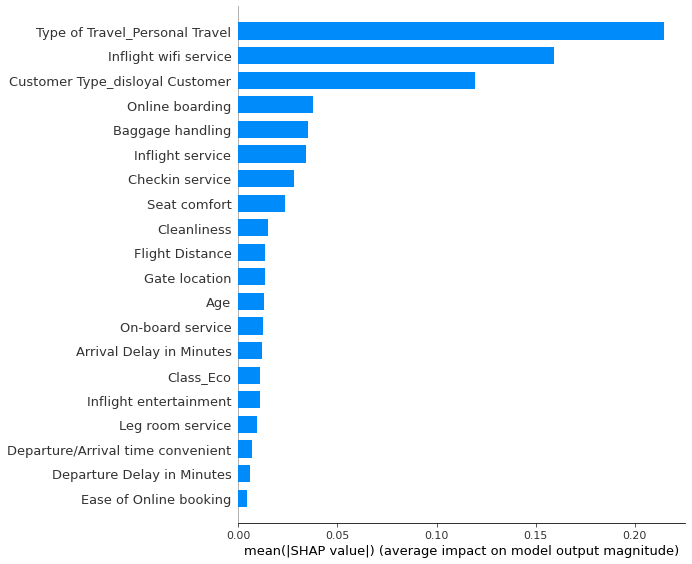

In [18]:
shap.summary_plot(shap_values, X_val.values, plot_type="bar",
                  feature_names = X_val.columns)

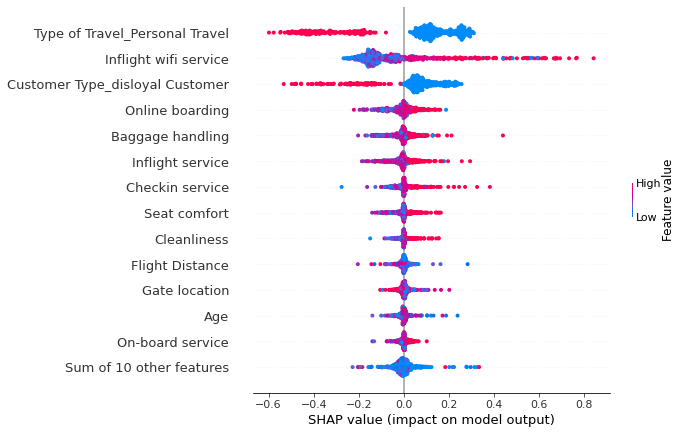

In [19]:
shap.plots.beeswarm(shap_values,max_display=14)

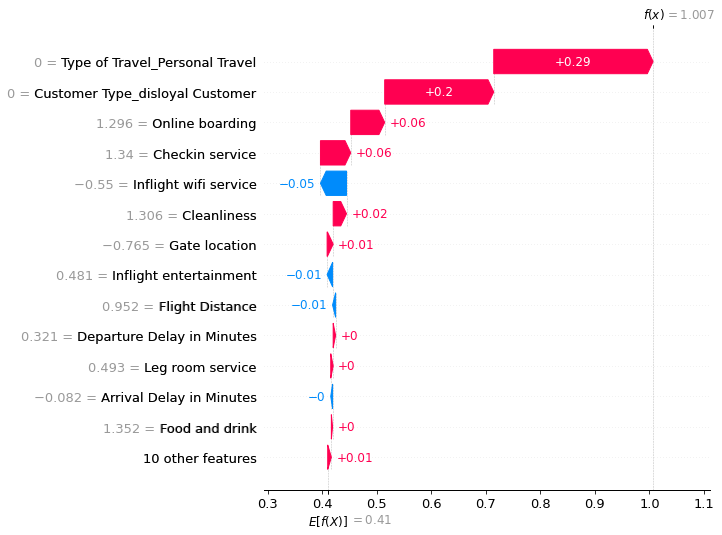

In [20]:
shap.plots.waterfall(shap_values[0], max_display=14)

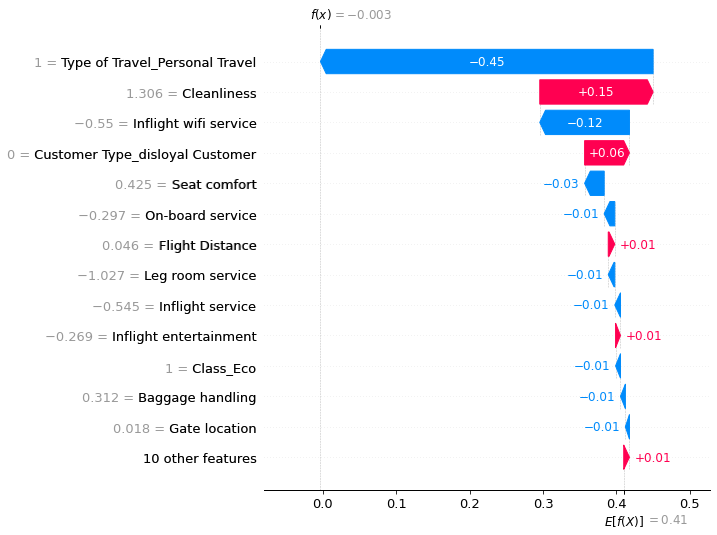

In [21]:
shap.plots.waterfall(shap_values[1], max_display=14)

Wnioski dla modelu `XGBoost` są analogiczne do tych wyciągniętych dla modelu `RandomForest`. Do niewielu różnic można zaliczyć to, że `RandomForest` przywiązywał większą wagę do zmiennych takich jak na przykład `Class_Eco`, `Online Boarding` czy `Inflight entertainment`.

## Dane z zadaniem regresji

### Preprocessing oraz odtworzenie najbardziej dokładnych modeli


W Pracy Domowej 2, rozważyłem podział zbioru na taki bez kolumny `generation_name` oraz taki bez wierszy z brakami w tej kolumnie (albowiem stanowią one ok. 25% wszystkich wierszy). Wtedy model `RandomForest` niezależnie od danych miał podobne wyniki, lecz model `XGboost` był lepszy dla danych zawierających wszystkie kolumny, dlatego na nich będę prowadził dalsze operacje.

In [35]:
def show_model_metrics_regression(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"RMSE Error: {mean_squared_error(y_val, y_pred)}")
    print(f"R2 Score: {r2_score(y_val, y_pred)}")

In [49]:
cars_df = cars_df.drop(columns = ["Unnamed: 0"], axis=1)

cars_df["years_old"] = 2022 - cars_df["year"]
cars_df.drop(columns=["year"], axis=1, inplace=True)

cars_df = cars_df[~cars_df["generation_name"].isna()]

numeric_columns = list(cars_df._get_numeric_data().columns)

for col in numeric_columns:
    transf1 = cars_df[col].values.reshape(-1,1)
    scaler1 = StandardScaler().fit(transf1)
    cars_df[col] = scaler1.transform(transf1)
    
numeric_columns = set(cars_df._get_numeric_data().columns)
all_columns = set(cars_df.columns)

cat_cols = list(all_columns.difference(numeric_columns))

for col in cat_cols:
    encoded2 = pd.get_dummies(cars_df[col].astype(str), prefix=str(col))
    encoded2.drop(columns=encoded2.columns[0], axis=1, inplace=True)
    cars_df.drop(columns=[col], axis=1, inplace=True)
    cars_df = pd.concat([cars_df, encoded2], axis=1) 

In [50]:
y = cars_df["price"]
X = cars_df.drop("price", axis= 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=420, test_size=0.125)

#### RandomForest

In [51]:
rndForest2 = RandomForestRegressor(n_jobs=-1)
rndForest2.fit(X_train, y_train)
y_pred = rndForest2.predict(X_val)

In [52]:
print("Train set")
show_model_metrics_regression(rndForest2, X_train, y_train)
print("----------")
print("Val set")
show_model_metrics_regression(rndForest2, X_val, y_val)

Train set
RMSE Error: 0.011098183379477496
R2 Score: 0.9891469114379773
----------
Val set
RMSE Error: 0.04687370233622988
R2 Score: 0.9498704926175441


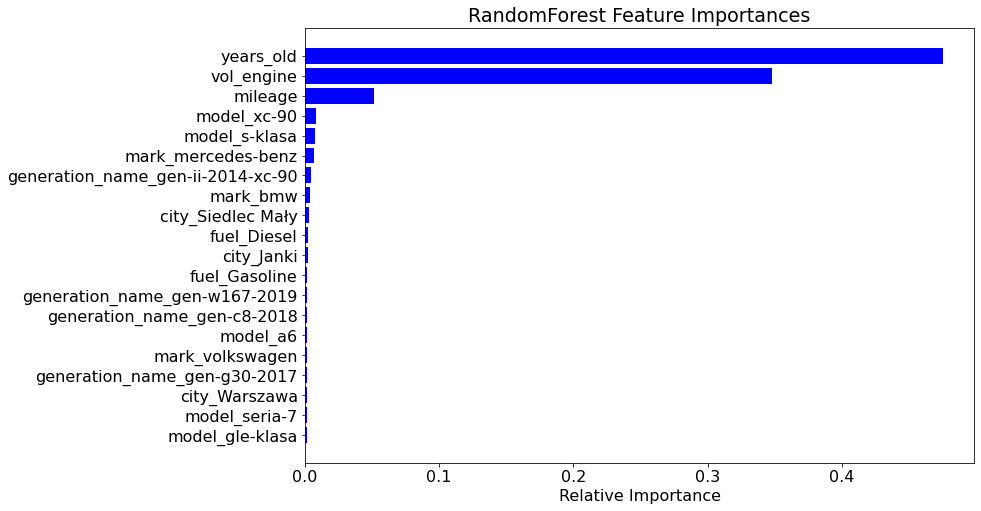

In [53]:
importances = pd.DataFrame([X_train.columns.values, rndForest2.feature_importances_]).T
importances.columns = ["Feature", "importance"]
importances = importances.sort_values('importance')
plt.title('RandomForest Feature Importances')
plt.barh(importances['Feature'].iloc[-20:], importances['importance'].iloc[-20:], color='blue', align='center')
plt.xlabel('Relative Importance')
plt.show()

In [82]:
X_sample = shap.utils.sample(X_val, 20)
explainer = shap.Explainer(rndForest2.predict, X_sample)
shap_values = explainer(X_sample)

Permutation explainer: 21it [11:09, 33.45s/it]                        


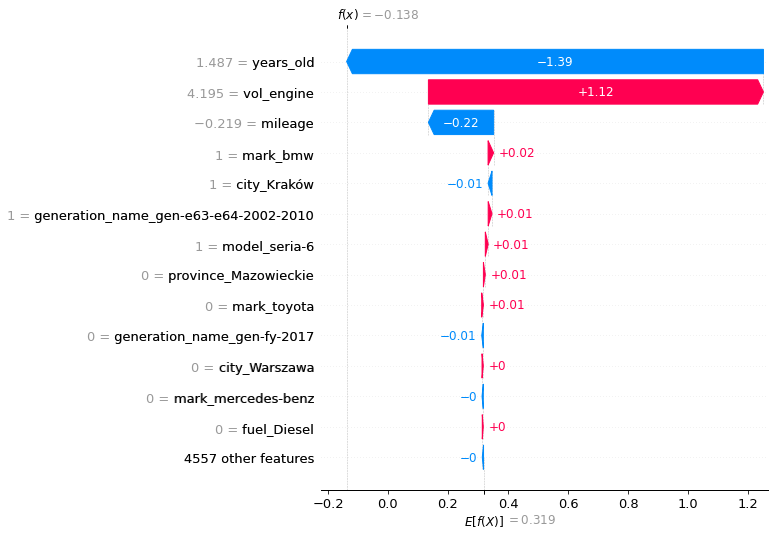

In [102]:
shap.plots.waterfall(shap_values[14], max_display=14)

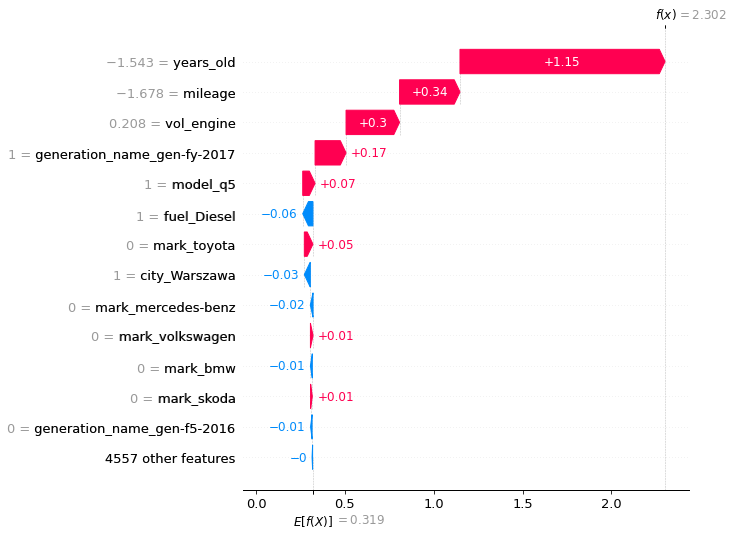

In [87]:
shap.plots.waterfall(shap_values[11], max_display=14)

#### XGBoost

In [59]:
xgb_cls2 = xgb.XGBRegressor(objective="reg:squarederror", max_depth=20, seed = 420, use_label_encoder=False)
xgb_cls2.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

[0]	validation_0-error:-0.39694
[1]	validation_0-error:-0.39745
[2]	validation_0-error:-0.39781
[3]	validation_0-error:-0.39807
[4]	validation_0-error:-0.39803
[5]	validation_0-error:-0.39805
[6]	validation_0-error:-0.39836
[7]	validation_0-error:-0.39866
[8]	validation_0-error:-0.39880
[9]	validation_0-error:-0.39900
[10]	validation_0-error:-0.39940
[11]	validation_0-error:-0.39934
[12]	validation_0-error:-0.39936
[13]	validation_0-error:-0.39935
[14]	validation_0-error:-0.39935
[15]	validation_0-error:-0.39965
[16]	validation_0-error:-0.39968
[17]	validation_0-error:-0.39979
[18]	validation_0-error:-0.39981
[19]	validation_0-error:-0.40025
[20]	validation_0-error:-0.40022
[21]	validation_0-error:-0.40026
[22]	validation_0-error:-0.40035
[23]	validation_0-error:-0.40028
[24]	validation_0-error:-0.40022
[25]	validation_0-error:-0.40018
[26]	validation_0-error:-0.40008
[27]	validation_0-error:-0.40022
[28]	validation_0-error:-0.40022
[29]	validation_0-error:-0.40026
[30]	validation_0-er

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=420,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=420,
             subsample=1, tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [61]:
print("Train set")
show_model_metrics_regression(xgb_cls2, X_train, y_train)
print("----------")
print("Val set")
show_model_metrics_regression(xgb_cls2, X_val, y_val)

Train set
RMSE Error: 0.004466034298495638
R2 Score: 0.9956325946233476
----------
Val set
RMSE Error: 0.06526887814793778
R2 Score: 0.9301976045013041


In [103]:
explainer = shap.Explainer(xgb_cls2.predict, X_sample)
shap_values = explainer(X_sample)

Permutation explainer: 21it [08:15, 24.78s/it]                        


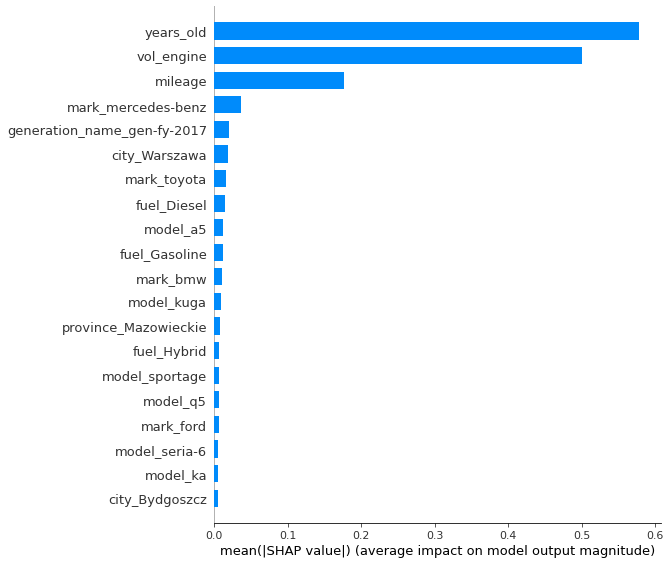

In [104]:
shap.summary_plot(shap_values, X_val.values, plot_type="bar",
                  feature_names = X_val.columns)

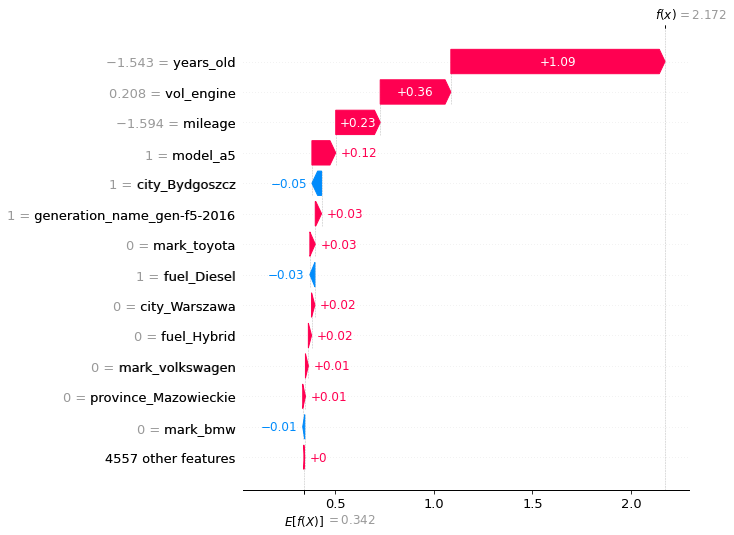

In [74]:
shap.plots.waterfall(shap_values[19], max_display=14)

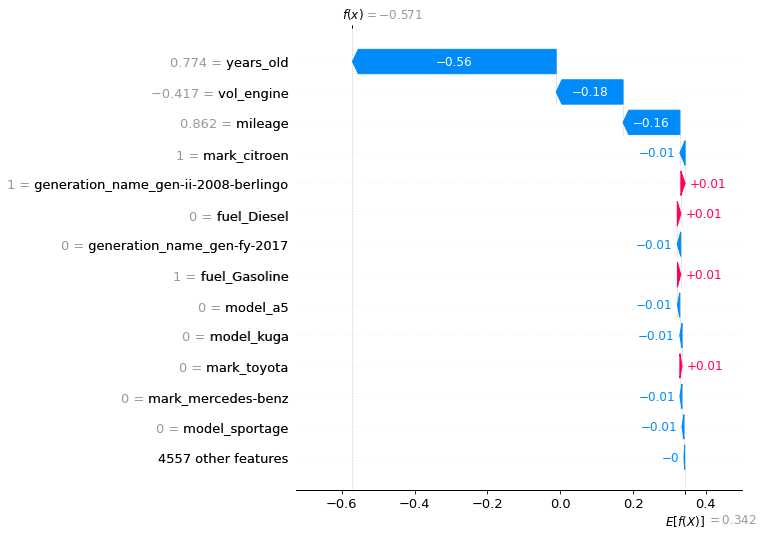

In [106]:
shap.plots.waterfall(shap_values[3], max_display=14)

W zadaniu regresji, w który chcemy przewidzieć cenę samochodu, oba modele zachowują się praktycznie tak samo. Do trzech najbardziej istotnych zmiennych w mniemaniu modeli należą:
1. wiek, 
2. przebieg, 
3. moc silnika

Niewątpliwie są to kluczowe aspekty, na które zwracamy uwagę przy zakupie samochodu, więc działanie modeli jest jak najbardziej zgodne z nasza intuicją.  

Mały wiek, niski przebieg oraz duża moc silnika - takie wartości przyczyniają się do zwiększenia przewidywanej przez modele ceny samochodu. Natomiat gdy samochód jest stary, sporo już przejechał i posiada silnik o małej mocy to wtedy jego cena naturalnie maleje w oczach wytrenowanych modeli. 